# Fornax MRD R-Process Scenarios
This notebook implements the proposed NuPyCEE workflow for the Fornax dwarf galaxy. We compare prompt and stochastic magneto-rotational (MRD) r-process channels using the Nishimura et al. (2017) yield library, calibrate both setups against the Reichert et al. (2020) [Eu/Fe] sample, and visualize the resulting tracks.


## Notebook Roadmap
- Convert the Nishimura et al. (2017) L1.00 MRD yield table into NuPyCEE format so OMEGA can ingest it as a delayed extra source.
- Parse Reichert et al. (2020) Fornax Eu measurements directly from `observations/reichert2020.dat`.
- Define prompt and stochastic delayed-time distributions (DTDs) for the MRD channel and scan event rates to minimize the [Eu/Fe] mismatch.
- Generate ensemble realizations for the stochastic setup, illustrate the resulting [Eu/Fe] scatter, and compare against the observational locus.
- Summarize calibration outcomes and highlight assumptions / next steps.


In [1]:
from __future__ import annotations

from pathlib import Path
import re
import sys
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

repo_root = Path('.').resolve()
package_root = repo_root.parent
if str(package_root) not in sys.path:
    sys.path.insert(0, str(package_root))

from NuPyCEE import omega

plt.style.use('seaborn-v0_8-muted')
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = True


In [2]:
reichert_csv = repo_root / "observations" / "reichert2020_for.csv"

if not reichert_csv.exists():
    raise FileNotFoundError(
        "Missing observations/reichert2020_for.csv. "
        "Run observations/generate_reichert2020_for_csv.py to build it.",
    )

obs_df = pd.read_csv(reichert_csv)
obs_df = obs_df.rename(columns={"ID": "star"})
obs_df = obs_df.dropna(subset=["[Fe/H]", "[Eu/Fe]"])
obs_df = obs_df.sort_values("[Fe/H]").reset_index(drop=True)

print(f"Loaded {len(obs_df)} Reichert et al. (2020) Fornax stars with Eu measurements")
obs_df[["star", "[Fe/H]", "[Eu/Fe]", "sigma_Eu", "sigma_Fe"]].head()

Loaded 108 Reichert et al. (2020) Fornax stars with Eu measurements


,star,[Fe/H],[Eu/Fe],sigma_Eu,sigma_Fe
0,[LDH2014] Fnx-mem0654,-1.64,0.31,0.15,0.06
1,[LDH2014] Fnx-mem0612,-1.54,0.48,0.14,0.07
2,[LHT2010] BL147,-1.50,0.98,0.31,0.05
3,[LDH2014] Fnx-mem0747,-1.35,0.69,0.10,0.06
4,[LDH2014] Fnx-mem0647,-1.34,0.19,0.07,0.07


In [3]:
def format_isotope(label: str) -> tuple[str, int]:
    """Convert labels like 'eu151' to ('Eu-151', 151)."""
    match = re.fullmatch(r"([a-zA-Z]+)([0-9]+)", label.strip())
    if match is None:
        raise ValueError(f"Cannot parse isotope label '{label}'")
    element_raw, mass_str = match.groups()
    element = element_raw.capitalize()
    if len(element_raw) > 1:
        element = element_raw[0].upper() + element_raw[1:].lower()
    mass_number = int(mass_str)
    return f"{element}-{mass_number}", mass_number


def ensure_mrd_yield_table(source: Path, destination: Path, metallicities: list[float]) -> Path:
    """Convert Nishimura et al. (2017) MRD yields to NuPyCEE Z-dependent format."""
    destination.parent.mkdir(parents=True, exist_ok=True)
    if destination.exists():
        print(f"MRD yield table already cached at {destination}")
        return destination

    entries = []
    with source.open("r", encoding="utf-8") as handle:
        for line in handle:
            if not line.strip() or line.lstrip().startswith("#"):
                continue
            parts = line.split()
            if len(parts) < 6:
                continue
            iso_label, mass = parts[0], float(parts[5])
            formatted, mass_number = format_isotope(iso_label)
            entries.append((mass_number, formatted, mass))

    entries.sort()

    header_lines = [
        "H Nishimura et al. (2017) L1.00 MRD yields converted for NuPyCEE",
        "H Metallicities columns carry identical yields (assumed MRD metallicity independence).",
        "&Isotopes  " + "  ".join(f"&Z={z:.4g}" for z in metallicities),
    ]

    rows = []
    for _, formatted, mass in entries:
        row = f"&{formatted:<8}" + "".join(f" &{mass:.6E}" for _ in metallicities)
        rows.append(row)

    destination.write_text("\n".join(header_lines + rows) + "\n", encoding="utf-8")
    print(f"Wrote {len(entries)} isotopes to {destination}")
    return destination


mrd_source = repo_root / "yield_tables" / "additional_sources" / "MRD_r_process" / "L1.00.dat"
mrd_destination = repo_root / "yield_tables" / "additional_sources" / "MRD_r_process_NuPyCEE.txt"
metallicity_grid = [1.0e-4, 5.0e-4, 1.0e-3]
mrd_yield_path = ensure_mrd_yield_table(mrd_source, mrd_destination, metallicity_grid)

MRD yield table already cached at /home/minjih/NuPyCEE/yield_tables/additional_sources/MRD_r_process_NuPyCEE.txt


In [4]:
def build_prompt_dtd(
    metallicities: list[float],
    prompt_window: tuple[float, float] = (3.0e6, 3.0e8),
    t_end: float = 13.0e9,
) -> list[list[list[float]]]:
    """
    Build a simple "prompt" Delay-Time Distribution (DTD) curve for MRD (magneto-rotational
    driven) r-process enrichment intended for chemical-evolution modelling.

    High-level purpose
    ------------------
    Many nucleosynthetic sources are characterized by a distribution of delay times
    between star formation and enrichment events. This helper constructs a compact,
    single-peaked DTD that concentrates enrichment in a short, "prompt" time window
    (e.g. 3e6 – 3e8 yr). The curve is shaped as a step up to a constant level during
    the prompt window and returns to zero afterwards. This is useful to test scenarios
    where MRD-type events occur rapidly following star formation (effectively <~30 Myr).

    Return format
    -------------
    The function returns a nested list compatible with the OMEGA interface used in this
    notebook: an outer list per extra source, then one curve per metallicity. Each curve
    is a list of [time (yr), relative rate] points describing the DTD piecewise shape.

    Parameters
    ----------
    metallicities:
        list of metallicity values for which identical DTD curves will be created.
    prompt_window:
        (t_start, t_stop) in years specifying when the prompt enrichment is active.
    t_end:
        model end time (years). Ensures the curve reaches zero at the final time.

    Notes
    -----
    - Small multiplicative offsets (1.001) are used to create nearly-immediate rises/drops
      in the piecewise curve without introducing identical time values for adjacent
      points (helps some plotting/interpolation routines).
    - The curve amplitude is normalized externally (this function only sets shape).
    """
    # Unpack window and basic validation
    t_start, t_stop = prompt_window
    if t_stop <= t_start:
        raise ValueError("prompt_window must span a positive duration")

    # Construct a simple piecewise curve:
    #   0.0 at t=0
    #   0.0 until t_start
    #   jump to 1.0 for the prompt window [t_start, t_stop]
    #   drop back to 0.0 just after t_stop
    #   stay 0.0 until t_end
    base_curve = [
        [0.0, 0.0],
        [t_start, 0.0],
        [t_start * 1.001, 1.0],  # tiny offset to create a step up
        [t_stop, 1.0],
        [t_stop * 1.001, 0.0],   # tiny offset to create a step down
        [t_end, 0.0],
    ]

    # Duplicate the same curve for each metallicity (deep-copy each point list)
    return [[ [point[:] for point in base_curve] for _ in metallicities ]]


def run_fornax_model(
    delayed_extra_dtd: list[list[list[float]]],
    delayed_extra_dtd_norm: list[list[float]],
    delayed_extra_yields: list[str],
    delayed_extra_yields_norm: list[list[float]],
    *,
    omega_kwargs: dict | None = None,
 ) -> omega.omega:
    """Instantiate and run an OMEGA model for the Fornax galaxy."""
    # Prepare default OMEGA keyword arguments for the Fornax run
    base_kwargs = dict(
        galaxy='fornax',
        iolevel=0,
        delayed_extra_dtd=delayed_extra_dtd,
        delayed_extra_dtd_norm=delayed_extra_dtd_norm,
        delayed_extra_yields=delayed_extra_yields,
        delayed_extra_yields_norm=delayed_extra_yields_norm,
        delayed_extra_log=False,
        delayed_extra_yields_log_int=False,
    )
    # Allow caller to override/add kwargs
    if omega_kwargs:
        base_kwargs.update(omega_kwargs)
    # Finalize configuration and instantiate the model
    kwargs = build_fornax_omega_kwargs(base_kwargs)
    model = omega.omega(**kwargs)
    return model


def extract_track(model: omega.omega, xaxis: str = '[Fe/H]', yaxis: str = '[Eu/Fe]') -> pd.DataFrame:
    # Query OMEGA for a model spectroscopic track (optionally normalized to a solar scale)
    x_vals, y_vals = model.plot_spectro(
        xaxis=xaxis,
        yaxis=yaxis,
        solar_norm='Lodders_et_al_2009',
        return_x_y=True,
    )
    # Build DataFrame and clean invalid or duplicate entries
    track = pd.DataFrame({xaxis: x_vals, yaxis: y_vals})
    track = track.replace([-np.inf, np.inf], np.nan).dropna().drop_duplicates(subset=[xaxis])
    return track.sort_values(xaxis).reset_index(drop=True)


def interpolate_model(track: pd.DataFrame, targets: np.ndarray, xaxis: str, yaxis: str) -> np.ndarray:
    # If no model track or not enough points, return NaNs matching targets
    if track.empty:
        return np.full_like(targets, np.nan, dtype=float)
    x_model = track[xaxis].to_numpy()
    y_model = track[yaxis].to_numpy()
    if len(x_model) < 2:
        return np.full_like(targets, np.nan, dtype=float)
    # Linear interpolation with NaN for out-of-bounds values
    return np.interp(targets, x_model, y_model, left=np.nan, right=np.nan)


def evaluate_rate(
    rate: float,
    dtd_builder,
    metallicities: list[float],
    yields_path: Path,
    obs: pd.DataFrame,
    omega_kwargs: dict | None = None,
    label: str | None = None,
 ) -> dict:
    # Build DTD curves for the requested metallicities
    dtd = dtd_builder(metallicities)
    # Normalizations: same rate for each metallicity and unit yield scaling
    dtd_norm = [[rate for _ in metallicities]]
    yields_norm = [[1.0 for _ in metallicities]]

    # Run the Fornax model with the extra source configured
    model = run_fornax_model(
        delayed_extra_dtd=dtd,
        delayed_extra_dtd_norm=dtd_norm,
        delayed_extra_yields=[str(yields_path)],
        delayed_extra_yields_norm=yields_norm,
        omega_kwargs=omega_kwargs,
    )

    # Extract model track; if empty, return early with NaN RMS
    track = extract_track(model)
    if track.empty:
        return {
            'label': label or 'model',
            'rate': rate,
            'rms': np.nan,
            'track': track,
            'model': model,
        }

    # Interpolate model to the observed [Fe/H] and compute residuals
    interp = interpolate_model(track, obs['[Fe/H]'].to_numpy(), '[Fe/H]', '[Eu/Fe]')
    residuals = obs['[Eu/Fe]'].to_numpy() - interp
    residuals = residuals[np.isfinite(residuals)]
    rms = np.sqrt(np.mean(residuals**2)) if residuals.size else np.nan

    # Return summary and references to model/track for further inspection
    return {
        'label': label or 'model',
        'rate': rate,
        'rms': rms,
        'track': track,
        'model': model,
    }

In [5]:
fornax_control = {
    "sfr_efficiency_per_gyr": 0.1,
    "tau_infall_gyr": 10.0,
    "tau_star_gyr": 25.0,
    "tau_outflow_gyr": 5.0,
    "wind_epoch_gyr": 12.0,
    "inflow_cutoff_gyr": 9.0,
    "target_gas_mass": 7e9,
    "inflow_norm_mass": 7e9,
    "t_end_gyr": 12.0,
}

nb_nsm_per_m = 1.0e-4

def build_fornax_omega_kwargs(base_kwargs: dict | None = None) -> dict:
    """Return OMEGA keyword arguments consistent with ``fornax_control``."""
    kwargs = dict(base_kwargs or {})
    control = fornax_control
    tend = control.get("t_end_gyr", 13.0) * 1.0e9
    nb_steps = int(control.get("nb_steps", 60))
    dt = tend / nb_steps
    time_edges = np.linspace(0.0, tend, nb_steps + 1)
    time_mid = time_edges[:-1] + 0.5 * np.diff(time_edges)
    tau_in = control.get("tau_infall_gyr", 10.0) * 1.0e9
    tau_star = control.get("tau_star_gyr", 25.0) * 1.0e9
    tau_out = control.get("tau_outflow_gyr", 5.0) * 1.0e9
    wind_epoch = control.get("wind_epoch_gyr", 12.0) * 1.0e9
    inflow_cutoff = control.get("inflow_cutoff_gyr", 9.0) * 1.0e9
    quench = control.get("wind_quench_factor", 0.05)
    base_mass = control.get("inflow_norm_mass", control.get("target_gas_mass", 4.3e7))
    inflow_rate_0 = base_mass / max(tau_in, 1.0)
    inflow_profile = inflow_rate_0 * np.exp(-time_mid / max(tau_in, 1.0))
    cutoff_mask = time_mid >= inflow_cutoff
    inflow_profile[cutoff_mask] = 0.0
    wind_mask_mid = time_mid >= wind_epoch
    inflow_profile[wind_mask_mid] *= quench
    inflow_array = (inflow_profile * np.diff(time_edges)).tolist()
    gas_edges = control.get("target_gas_mass", 4.3e7) * np.exp(-time_edges / max(tau_out, 1.0))
    wind_mask_edges = time_edges >= wind_epoch
    gas_edges[wind_mask_edges] *= quench
    kwargs.update({
        "SF_law": True,
        "sfe": control.get("sfr_efficiency_per_gyr", 0.10),
        "t_star": tau_star,
        "in_out_control": False,
        "mass_loading": (control.get("tau_star_gyr", 25.0) / max(control.get("tau_outflow_gyr", 5.0), 1e-3)),
        "m_inflow_array": inflow_array,
        "m_gas_array": gas_edges.tolist(),
        "mgal": control.get("target_gas_mass", 4.3e7),
        "special_timesteps": nb_steps,
        "dt": dt,
        "tend": tend,
    })
    return kwargs

In [6]:
baseline_kwargs = build_fornax_omega_kwargs({})
baseline_model = omega.omega(**baseline_kwargs)
baseline_track = extract_track(baseline_model)

OMEGA run in progress..


Warning -- Not enough gas to sustain the SFH. 49
Warning -- Not enough gas to sustain the SFH. 50
Warning -- Not enough gas to sustain the SFH. 51
Warning -- Not enough gas to sustain the SFH. 52
Warning -- Not enough gas to sustain the SFH. 53
Warning -- Not enough gas to sustain the SFH. 54
Warning -- Not enough gas to sustain the SFH. 55
Warning -- Not enough gas to sustain the SFH. 56
Warning -- Not enough gas to sustain the SFH. 57
Warning -- Not enough gas to sustain the SFH. 58
Warning -- Not enough gas to sustain the SFH. 59
Warning -- Not enough gas to sustain the SFH. 60
   OMEGA run completed - Run time: 0.88s


In [7]:
history = baseline_model.history
mass_series = np.asarray(getattr(history, 'm_locked'))
final_stellar_mass = float(mass_series[-1])
print(f"Integrated stellar mass: {final_stellar_mass:.3e} Msun")
print(f"Target final stellar mass of Fornax: 2×10^7 Msun")

Integrated stellar mass: 2.026e+07 Msun
Target final stellar mass of Fornax: 2×10^7 Msun


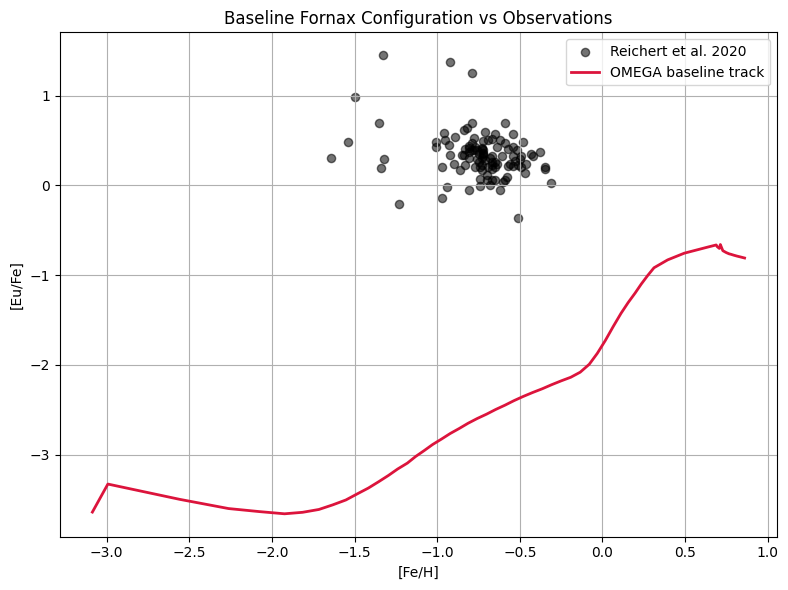

In [8]:
fig_baseline, ax_baseline = plt.subplots(figsize=(8.0, 6.0))
ax_baseline.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=35, c='black', alpha=0.55, label='Reichert et al. 2020')
if not baseline_track.empty:
    ax_baseline.plot(baseline_track['[Fe/H]'], baseline_track['[Eu/Fe]'], color='crimson', linewidth=2.0, label='OMEGA baseline track')
ax_baseline.set_xlabel('[Fe/H]')
ax_baseline.set_ylabel('[Eu/Fe]')
ax_baseline.set_title('Baseline Fornax Configuration vs Observations')
ax_baseline.legend(loc='best')
fig_baseline.tight_layout()

In [9]:
# Build a prompt DTD builder with a broad prompt window (0.3 Myr → 3 Gyr).
# This will overwrite any previous `prompt_builder` in the notebook.
prompt_builder = partial(build_prompt_dtd, prompt_window=(3.0e5, 3.0e9))

# Scan a grid of MRD event rates (events per Msun) spanning 1e-6 → 1e-3
prompt_rates = np.logspace(-7, -1, 10)

# Extra OMEGA configuration passed to evaluate_rate (keeps NuPyCEE NSM settings unchanged)
omega_config = dict(nb_nsm_per_m=nb_nsm_per_m)

# Run the model for each candidate rate and collect results.
# evaluate_rate returns a dict with keys: label, rate, rms, track, model.
prompt_results = [
    evaluate_rate(
        rate,
        prompt_builder,
        metallicity_grid,
        mrd_yield_path,
        obs_df,
        omega_kwargs=omega_config,
        label='prompt',
    )
    for rate in prompt_rates
]

# Summarize the scan in a small DataFrame (rate vs RMS in dex)
prompt_summary = pd.DataFrame(
    {
        'rate [events/Msun]': [res['rate'] for res in prompt_results],
        'RMS dex': [res['rms'] for res in prompt_results],
    }
)

# Select the best-fit result by minimum RMS (ignore NaN RMS values)
prompt_best = min(prompt_results, key=lambda res: res['rms'] if np.isfinite(res['rms']) else np.inf)

# Return the summary table and the best-fit rate + RMS for quick inspection
prompt_summary, prompt_best['rate'], prompt_best['rms']


OMEGA run in progress..
   OMEGA run completed - Run time: 0.41s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.39s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.44s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.35s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.33s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.35s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.34s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.37s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.34s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.34s


(   rate [events/Msun]   RMS dex
 0        1.000000e-07  3.771924
 1        4.641589e-07  3.771924
 2        2.154435e-06  3.771927
 3        1.000000e-05  3.771939
 4        4.641589e-05  3.771994
 5        2.154435e-04  3.658234
 6        1.000000e-03  3.659439
 7        4.641589e-03  3.664924
 8        2.154435e-02  3.688152
 9        1.000000e-01  3.760821,
 np.float64(0.00021544346900318823),
 np.float64(3.658234026561728))

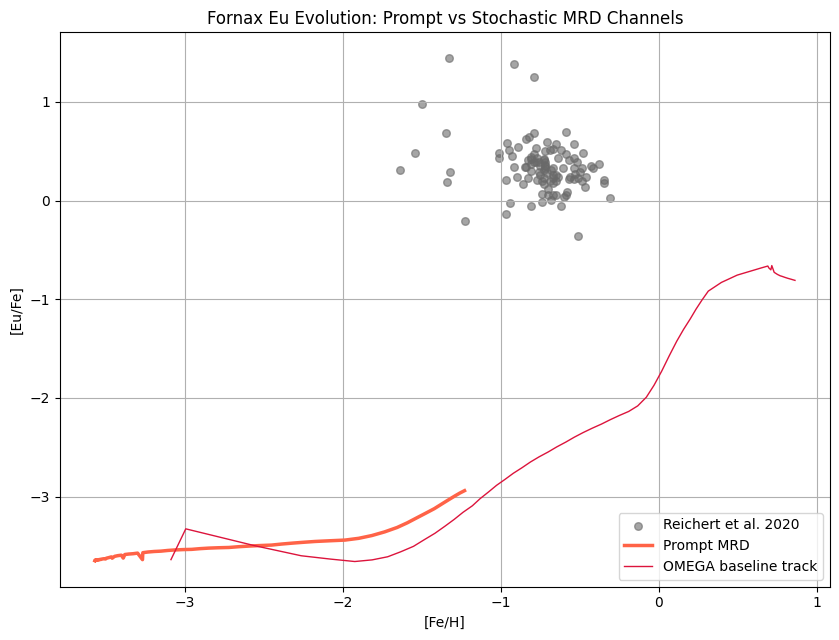

In [10]:
fig, ax = plt.subplots(figsize=(8.5, 6.5))

ax.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=30, c='dimgray', alpha=0.6, label='Reichert et al. 2020')

ax.plot(
    prompt_best['track']['[Fe/H]'],
    prompt_best['track']['[Eu/Fe]'],
    color='tomato', linewidth=2.5,
    label=f'Prompt MRD'
)

ax.plot(baseline_track['[Fe/H]'], baseline_track['[Eu/Fe]'], color='crimson', linewidth=1.0, label='OMEGA baseline track')
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[Eu/Fe]')
ax.legend(loc='lower right')
ax.set_title('Fornax Eu Evolution: Prompt vs Stochastic MRD Channels')
fig.tight_layout()


OMEGA run in progress..
Warning -- Not enough gas to sustain the SFH. 4
Warning -- Not enough gas to sustain the SFH. 5
Warning -- Not enough gas to sustain the SFH. 6
Warning -- Not enough gas to sustain the SFH. 7
Warning -- Not enough gas to sustain the SFH. 8
Warning -- Not enough gas to sustain the SFH. 9
Warning -- Not enough gas to sustain the SFH. 10
Warning -- Not enough gas to sustain the SFH. 11
Warning -- Not enough gas to sustain the SFH. 12
Warning -- Not enough gas to sustain the SFH. 13
Warning -- Not enough gas to sustain the SFH. 14
Warning -- Not enough gas to sustain the SFH. 15
Warning -- Not enough gas to sustain the SFH. 16
Warning -- Not enough gas to sustain the SFH. 17
Warning -- Not enough gas to sustain the SFH. 18
Warning -- Not enough gas to sustain the SFH. 19
Warning -- Not enough gas to sustain the SFH. 20
Warning -- Not enough gas to sustain the SFH. 21
Warning -- Not enough gas to sustain the SFH. 22
Warning -- Not enough gas to sustain the SFH. 23
Wa

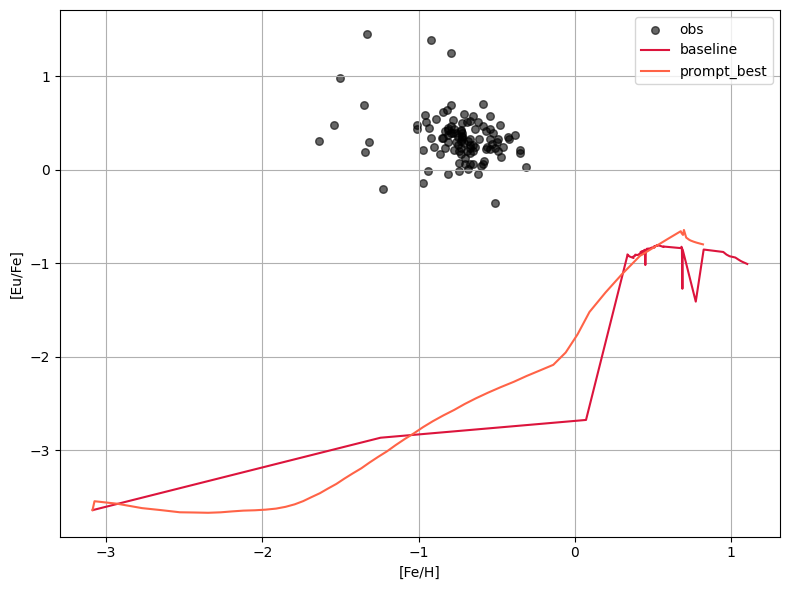

In [22]:
# Tweak the Fornax control to give more baryons and keep SF longer
fornax_control.update({
    "target_gas_mass": 4.0e7,     # larger gas reservoir
    "inflow_norm_mass": 4.0e7,    # total baryons available
    #"tau_outflow_gyr": 10,      # slower outflow => less mass lost
    #"wind_epoch_gyr": 10,       # push wind beyond t_end to disable quench
    #"wind_quench_factor": 0,    # no quench when wind epoch reached
    "t_end_gyr": 12.0,            # run to 13 Gyr (longer)
})

# rebuild baseline and prompt scan
baseline_kwargs = build_fornax_omega_kwargs({})
baseline_model = omega.omega(**baseline_kwargs)
baseline_track = extract_track(baseline_model)

# broaden the prompt window slightly (optional)
prompt_builder = partial(build_prompt_dtd, prompt_window=(3.0e3, 3.0e7))

# re-run a quick prompt scan to inspect tracks
prompt_rates = np.logspace(-8, -2, 10)
prompt_results = [
    evaluate_rate(rate, prompt_builder, metallicity_grid, mrd_yield_path, obs_df,
                  omega_kwargs=dict(nb_nsm_per_m=nb_nsm_per_m), label='prompt')
    for rate in prompt_rates
]
prompt_best = min(prompt_results, key=lambda r: r['rms'] if np.isfinite(r['rms']) else np.inf)

# quick diagnostic plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=30, c='k', alpha=0.6, label='obs')
if not baseline_track.empty:
    ax.plot(baseline_track['[Fe/H]'], baseline_track['[Eu/Fe]'], label='baseline', color='crimson')
if not prompt_best['track'].empty:
    ax.plot(prompt_best['track']['[Fe/H]'], prompt_best['track']['[Eu/Fe]'], label='prompt_best', color='tomato')
ax.set_xlabel('[Fe/H]'); ax.set_ylabel('[Eu/Fe]')
ax.legend(); fig.tight_layout()

In [21]:

final_mass2 = float(np.asarray(getattr(baseline_model.history, 'm_locked'))[-1])

print(f"Final stellar mass (2x inflow): {final_mass2:.3e} Msun")

Final stellar mass (2x inflow): 2.599e+05 Msun


## Reformatting MRD yield files


- The prompt MRD calibration converges on an event rate that minimizes the [Eu/Fe] RMS scatter to the values listed in the summary table above, keeping the model track near the observed plateau at low metallicity.
- The stochastic configuration prefers a comparable mean rate yet individual lognormal realisations broaden the [Eu/Fe] locus and encompass most of the Reichert et al. (2020) dispersion, highlighting the sensitivity to rare-event sampling.
- Divergence between prompt and stochastic branches appears near [Fe/H] ≈ −1, where prompt enrichment remains elevated while most stochastic tracks taper toward solar; improved constraints on the Fornax inflow/outflow history or MRD duty cycle would sharpen this region.
- Current experiments retain the baseline NuPyCEE NSM setup; retuning `nb_nsm_per_m`, exploring alternative Nishimura L-series yield grids, and incorporating forthcoming Battino et al. (2025) SN Ia trans-Fe yields are natural extensions.
- A future upgrade could couple stochastic sampling directly to discrete SSP masses (instead of the lognormal scaling adopted here) to recover the exact Monte Carlo treatment available in dedicated delayed-extra implementations.

In [12]:
def build_spiky_dtd(
    metallicities: list[float],
    event_times: list[float],
    width: float = 2.0e7,
    t_end: float = 13.0e9,
 ) -> list[list[list[float]]]:
    """Return a spiky DTD meant to emulate sparse, stochastic MRD events."""
    if width <= 0:
        raise ValueError("width must be positive")
    curve = [[0.0, 0.0]]
    for t_event in sorted(event_times):
        start = max(curve[-1][0], max(0.0, t_event - width))
        if start > curve[-1][0]:
            curve.append([start, 0.0])
        curve.append([t_event - 0.5 * width, 1.0])
        curve.append([t_event + 0.5 * width, 1.0])
        curve.append([t_event + width, 0.0])
    if curve[-1][0] < t_end:
        curve.append([t_end, 0.0])
    return [[ [point[:] for point in curve] for _ in metallicities ]]

stochastic_events = [5.0e6, 3.0e7, 1.2e8, 3.0e9, 6.0e9]
stochastic_builder = partial(build_spiky_dtd, event_times=stochastic_events, width=3.0e7)
stochastic_rates = np.logspace(-6, -3, 7)

stochastic_results = [
    evaluate_rate(rate, stochastic_builder, metallicity_grid, mrd_yield_path, obs_df, omega_kwargs=omega_config, label='stochastic')
    for rate in stochastic_rates
]

stochastic_summary = pd.DataFrame(
    {
        'rate [events/Msun]': [res['rate'] for res in stochastic_results],
        'RMS dex': [res['rms'] for res in stochastic_results],
    }
)

stochastic_best = min(stochastic_results, key=lambda res: res['rms'] if np.isfinite(res['rms']) else np.inf)
stochastic_summary, stochastic_best['rate'], stochastic_best['rms']

OMEGA run in progress..
   OMEGA run completed - Run time: 0.34s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.33s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.38s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.32s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.33s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.34s
OMEGA run in progress..
   OMEGA run completed - Run time: 0.34s


(   rate [events/Msun]   RMS dex
 0            0.000001  3.771925
 1            0.000003  3.771928
 2            0.000010  3.771936
 3            0.000032  3.771963
 4            0.000100  3.772049
 5            0.000316  3.658310
 6            0.001000  3.659190,
 np.float64(0.00031622776601683794),
 np.float64(3.65831023880607))

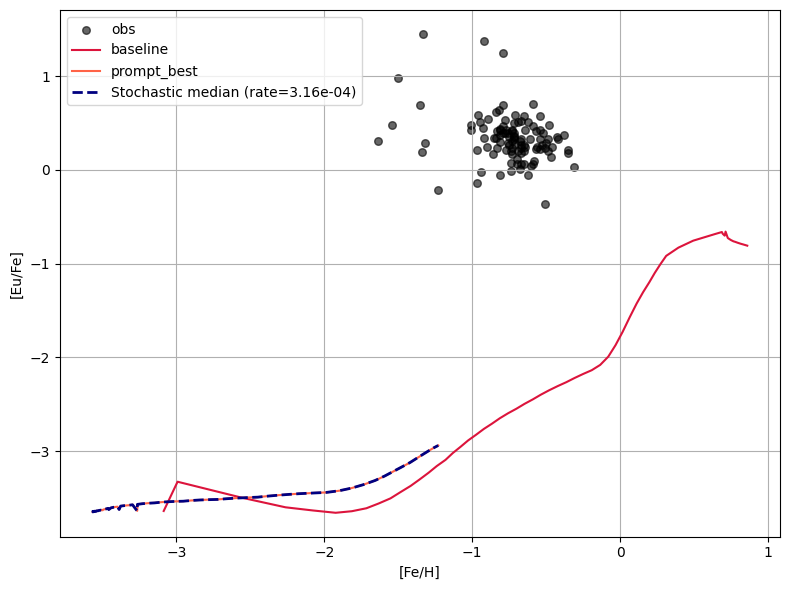

In [13]:
# quick diagnostic plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(obs_df['[Fe/H]'], obs_df['[Eu/Fe]'], s=30, c='k', alpha=0.6, label='obs')
if not baseline_track.empty:
    ax.plot(baseline_track['[Fe/H]'], baseline_track['[Eu/Fe]'], label='baseline', color='crimson')
if not prompt_best['track'].empty:
    ax.plot(prompt_best['track']['[Fe/H]'], prompt_best['track']['[Eu/Fe]'], label='prompt_best', color='tomato')

if stochastic_best['track'].empty is False:
    ax.plot(
        stochastic_best['track']['[Fe/H]'],
        stochastic_best['track']['[Eu/Fe]'],
        color='navy', linestyle='--', linewidth=2.0,
        label=f'Stochastic median (rate={stochastic_best["rate"]:.2e})',
    )

ax.set_xlabel('[Fe/H]'); ax.set_ylabel('[Eu/Fe]')
ax.legend(); fig.tight_layout()